## NiO M&M 2023 Notebook

Georgios Varnavides (gvarnavides@berkeley.edu)  
July 23 2023

This notebook perfoms the ptychographic analysis presented at M&M 2023 during [this presentation](https://gvarnavides.com/2023mm-presentation/).

### Bulk

In [1]:
import py4DSTEM
import numpy as np
from ase import io as ase_io
import abtem
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Ground Truth

In [2]:
afm_bulk_copout =  ase_io.read("NiO-bulk_atoms.xyz")

ground_truth_electrostatic = np.load("NiO-bulk_ground-truth_electrostatic.npy")
ground_truth_magnetic = np.load("NiO-bulk_ground-truth_magnetic.npy")

datacube_forward = py4DSTEM.read("NiO-bulk_forward_1e6.h5")
datacube_reverse = py4DSTEM.read("NiO-bulk_reverse_1e6.h5")

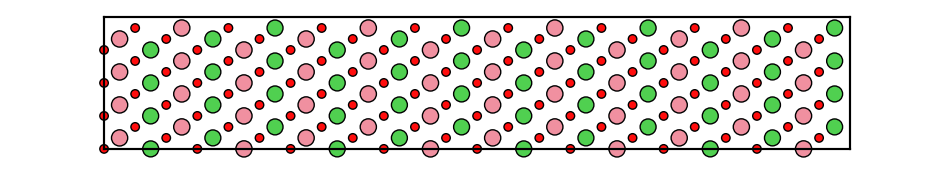

In [3]:
fig_atomic, ax = plt.subplots(figsize=(12,2))
abtem.show_atoms(afm_bulk_copout*(4,2,1),ax=ax)
ax.axis('off');

In [42]:
# fig_atomic.savefig("NiO-bulk_atomic-model.svg")

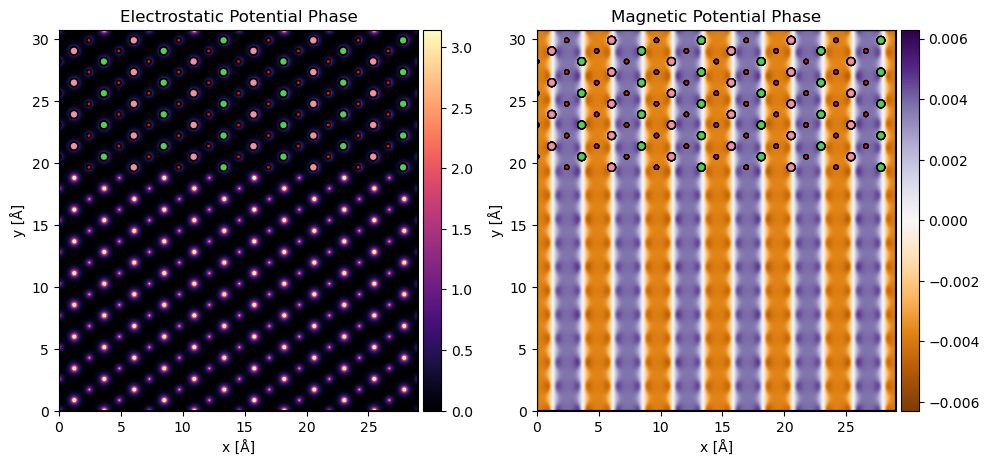

In [4]:
NiO_111_top_left = afm_bulk_copout*(2,6,8)
del NiO_111_top_left[np.where((NiO_111_top_left.positions[:,1]<19))[0]]

ground_truth_shape = ground_truth_electrostatic.shape
ground_truth_samping = [0.05,0.05]

extent_xy = [
    0,
    ground_truth_samping[0] * ground_truth_shape[0],
    0,
    ground_truth_samping[1] * ground_truth_shape[1],
]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

im1 = ax1.imshow(
    ground_truth_electrostatic.T,
    cmap='magma',
    origin='lower',
    vmax=np.pi,
    extent=extent_xy
)


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax1,scale_atoms=0.25)
ax1.set_xlim(extent_xy[0],extent_xy[1])
ax1.set_ylim(extent_xy[2],extent_xy[3])

ax1.set_title("Electrostatic Potential Phase")

im2=ax2.imshow(
    ground_truth_magnetic.T,
    origin='lower',
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax2,scale_atoms=0.25)
ax2.set_xlim(extent_xy[0],extent_xy[1])
ax2.set_ylim(extent_xy[2],extent_xy[3])
ax2.set_title("Magnetic Potential Phase");

fig.tight_layout();

In [5]:
# fig.savefig("NiO-bulk_ground-truth.png",transparent=True,bbox_inches='tight')

#### Naive Subtraction

In [6]:
ptycho_forward = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=datacube_forward,
    energy=200e3,
    verbose=False,
    defocus=300,
    object_padding_px=(0,0),
    device='gpu',
    semiangle_cutoff = 25,
    object_type='potential',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_center_of_mass=False,
    plot_probe_overlaps=False,
).reconstruct(
    progress_bar = True,
    reset=True,
    store_iterations = True,
    max_iter = 512,
    step_size=0.25,
    q_lowpass=2.5,
    normalization_min=1,
)

Reconstructing object and probe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.53 iter/s]


In [7]:
ptycho_reverse = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=datacube_reverse,
    energy=200e3,
    verbose=False,
    defocus=300,
    object_padding_px=(0,0),
    device='gpu',
    semiangle_cutoff = 25,
    object_type='potential',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_center_of_mass=False,
    plot_probe_overlaps=False,
).reconstruct(
    progress_bar = True,
    reset=True,
    store_iterations = True,
    max_iter = 512,
    step_size=0.25,
    q_lowpass=2.5,
    normalization_min=1,
)

Reconstructing object and probe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:27<00:00, 18.45 iter/s]


In [8]:
naive_electrostatic_phase = (ptycho_forward.object + ptycho_reverse.object)/2
naive_magnetic_phase = (ptycho_forward.object - ptycho_reverse.object)/2

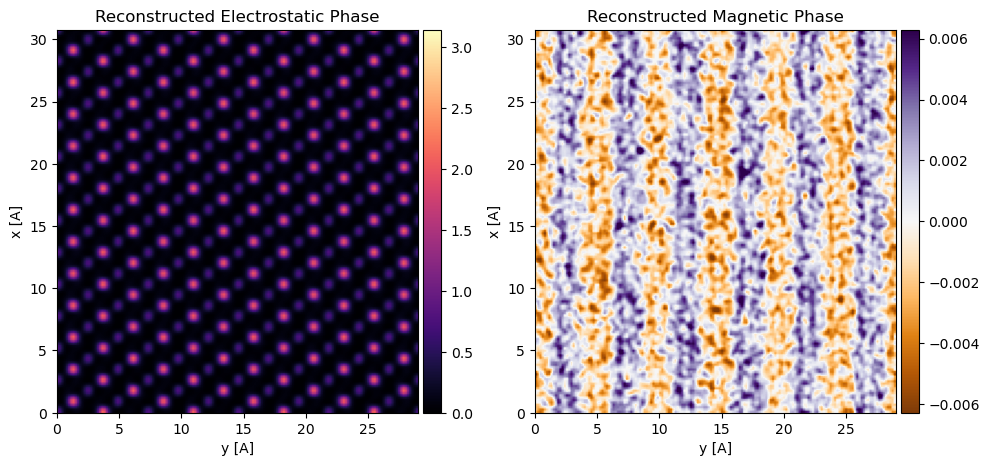

In [9]:
fig_naive, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

im1 = ax1.imshow(
    naive_electrostatic_phase.T,
    cmap='magma',
    origin='lower',
    vmax=np.pi,
    extent=extent_xy
)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

ax1.set_title("Reconstructed Electrostatic Phase")
ax1.set_ylabel("x [A]")
ax1.set_xlabel("y [A]")

im2=ax2.imshow(
    naive_magnetic_phase.T,
    origin='lower',
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax2.set_title("Reconstructed Magnetic Phase");
ax2.set_ylabel("x [A]")
ax2.set_xlabel("y [A]")

fig_naive.tight_layout();

In [13]:
# fig_naive.savefig("NiO-bulk_naive-recon.png",transparent=True,bbox_inches='tight')

#### Joint Reconstruction

In [10]:
ptycho = py4DSTEM.process.phase.SimultaneousPtychographicReconstruction(
    datacube=(datacube_reverse,datacube_forward),
    energy=200e3,
    verbose=False,
    defocus=300,
    object_padding_px=(0,0),
    device='gpu',
    semiangle_cutoff = 25,
    object_type='potential',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps=False,
).reconstruct(
    progress_bar = True,
    reset=True,
    store_iterations = True,
    max_iter = 512,
    step_size=0.25,
    q_lowpass_m=1.5,
    q_lowpass_e=2.5,
    normalization_min=1,
)

Reconstructing object and probe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.91 iter/s]


In [11]:
joint_electrostatic_phase, joint_magnetic_phase = ptycho.object

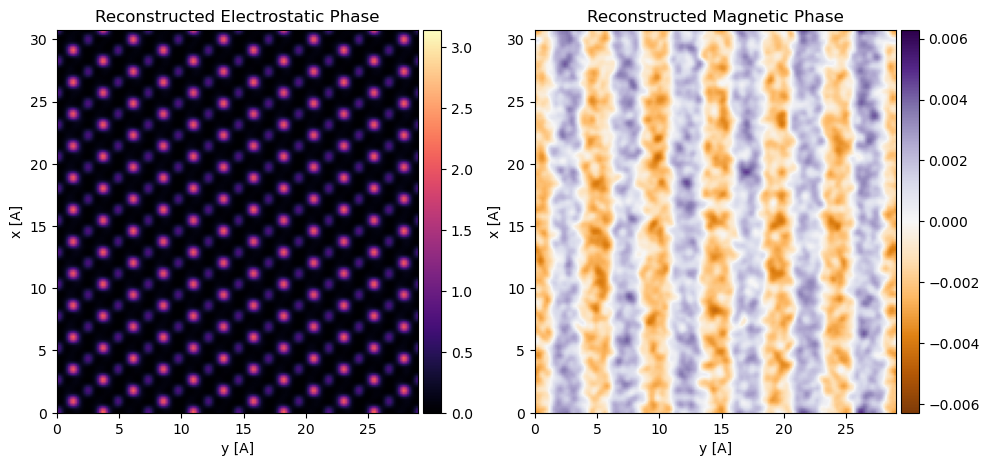

In [12]:
fig_joint, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

im1 = ax1.imshow(
    joint_electrostatic_phase.T,
    cmap='magma',
    origin='lower',
    vmax=np.pi,
    extent=extent_xy
)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

ax1.set_title("Reconstructed Electrostatic Phase")
ax1.set_ylabel("x [A]")
ax1.set_xlabel("y [A]")

im2=ax2.imshow(
    joint_magnetic_phase.T,
    origin='lower',
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax2.set_title("Reconstructed Magnetic Phase");
ax2.set_ylabel("x [A]")
ax2.set_xlabel("y [A]")

fig_joint.tight_layout();

In [17]:
# fig_joint.savefig("NiO-bulk_joint-recon.png",transparent=True,bbox_inches='tight')

### Twin

In [13]:
afm_twin =  ase_io.read("NiO-twin_atoms.xyz")

ground_truth_electrostatic = np.load("NiO-twin_ground-truth_electrostatic.npy")
ground_truth_magnetic = np.load("NiO-twin_ground-truth_magnetic.npy")

datacube_forward = py4DSTEM.read("NiO-twin_forward_1e6.h5")
datacube_reverse = py4DSTEM.read("NiO-twin_reverse_1e6.h5")

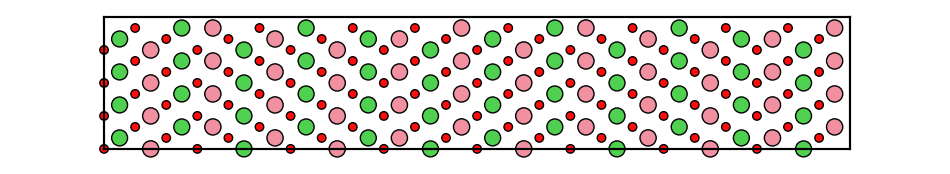

In [14]:
fig_atomic, ax = plt.subplots(figsize=(12,2))
abtem.show_atoms(afm_twin*(2,2,1),ax=ax)
ax.axis('off');

In [56]:
# fig_atomic.savefig("NiO-twin_atomic-model.svg")

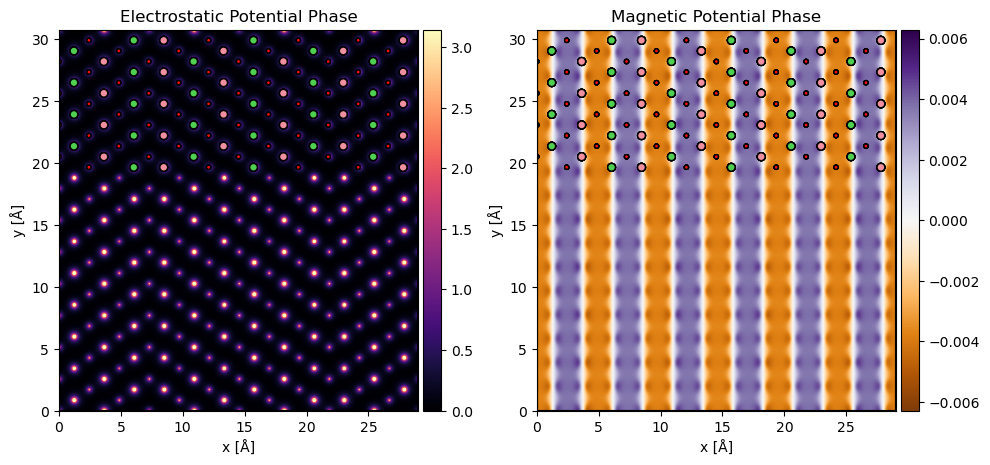

In [15]:
NiO_111_top_left = afm_twin*(1,6,8)
del NiO_111_top_left[np.where((NiO_111_top_left.positions[:,1]<19))[0]]

ground_truth_shape = ground_truth_electrostatic.shape
ground_truth_samping = [0.05,0.05]

extent_xy = [
    0,
    ground_truth_samping[0] * ground_truth_shape[0],
    0,
    ground_truth_samping[1] * ground_truth_shape[1],
]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

im1 = ax1.imshow(
    ground_truth_electrostatic.T,
    cmap='magma',
    origin='lower',
    vmax=np.pi,
    extent=extent_xy
)


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax1,scale_atoms=0.25)
ax1.set_xlim(extent_xy[0],extent_xy[1])
ax1.set_ylim(extent_xy[2],extent_xy[3])

ax1.set_title("Electrostatic Potential Phase")

im2=ax2.imshow(
    ground_truth_magnetic.T,
    origin='lower',
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax2,scale_atoms=0.25)
ax2.set_xlim(extent_xy[0],extent_xy[1])
ax2.set_ylim(extent_xy[2],extent_xy[3])
ax2.set_title("Magnetic Potential Phase");

fig.tight_layout();

In [20]:
# fig.savefig("NiO-twin_ground-truth.png",transparent=True,bbox_inches='tight')

In [16]:
ptycho = py4DSTEM.process.phase.SimultaneousPtychographicReconstruction(
    datacube=(datacube_reverse,datacube_forward),
    energy=200e3,
    verbose=False,
    defocus=300,
    object_padding_px=(0,0),
    device='gpu',
    semiangle_cutoff = 25,
    object_type='potential',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps=False,
).reconstruct(
    progress_bar = True,
    reset=True,
    store_iterations = True,
    max_iter = 512,
    step_size=0.25,
    q_lowpass_m=1.5,
    q_lowpass_e=2.5,
    normalization_min=1,
)

Reconstructing object and probe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.90 iter/s]


In [17]:
joint_electrostatic_phase, joint_magnetic_phase = ptycho.object

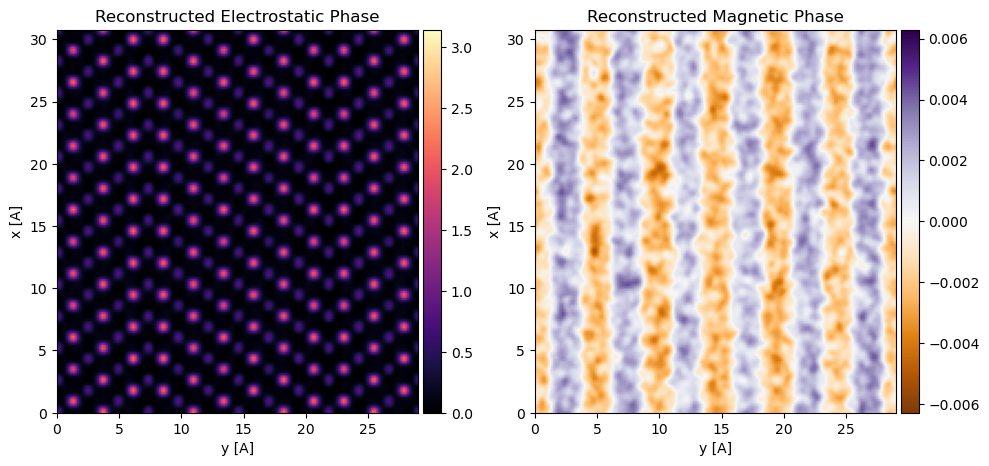

In [18]:
fig_joint, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

im1 = ax1.imshow(
    joint_electrostatic_phase.T,
    cmap='magma',
    origin='lower',
    vmax=np.pi,
    extent=extent_xy
)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

ax1.set_title("Reconstructed Electrostatic Phase")
ax1.set_ylabel("x [A]")
ax1.set_xlabel("y [A]")

im2=ax2.imshow(
    joint_magnetic_phase.T,
    origin='lower',
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax2.set_title("Reconstructed Magnetic Phase");
ax2.set_ylabel("x [A]")
ax2.set_xlabel("y [A]")

fig_joint.tight_layout();

In [24]:
# fig_joint.savefig("NiO-twin_joint-recon.png",transparent=True,bbox_inches='tight')

### Mix-Twin

In [19]:
mix_twin =  ase_io.read("NiO-mix-twin_atoms.xyz")

ground_truth_electrostatic = np.load("NiO-mix-twin_ground-truth_electrostatic.npy")
ground_truth_magnetic = np.load("NiO-mix-twin_ground-truth_magnetic.npy")

datacube_forward = py4DSTEM.read("NiO-mix-twin_forward_1e6.h5")
datacube_reverse = py4DSTEM.read("NiO-mix-twin_reverse_1e6.h5")

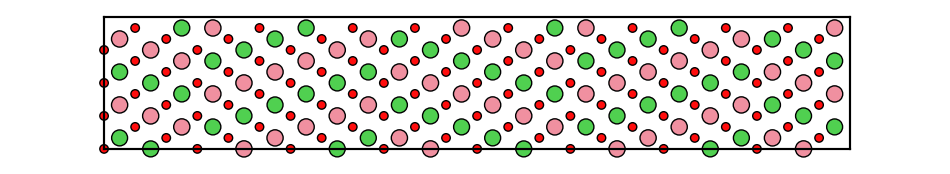

In [20]:
fig_atomic, ax = plt.subplots(figsize=(12,2))
abtem.show_atoms(mix_twin*(2,2,1),ax=ax)
ax.axis('off');

In [65]:
# fig_atomic.savefig("NiO-mix-twin_atomic-model.svg")

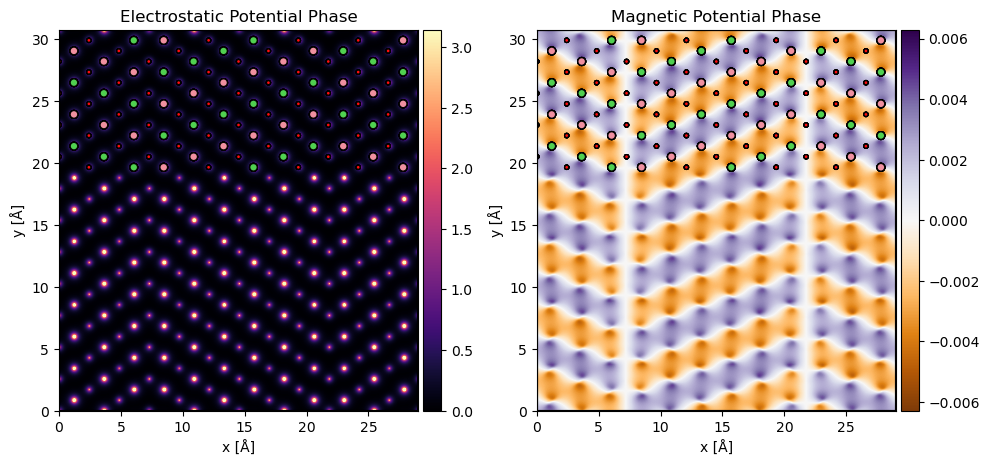

In [21]:
NiO_111_top_left = mix_twin*(1,6,8)
del NiO_111_top_left[np.where((NiO_111_top_left.positions[:,1]<19))[0]]

ground_truth_shape = ground_truth_electrostatic.shape
ground_truth_samping = [0.05,0.05]

extent_xy = [
    0,
    ground_truth_samping[0] * ground_truth_shape[0],
    0,
    ground_truth_samping[1] * ground_truth_shape[1],
]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

im1 = ax1.imshow(
    ground_truth_electrostatic.T,
    cmap='magma',
    origin='lower',
    vmax=np.pi,
    extent=extent_xy
)


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax1,scale_atoms=0.25)
ax1.set_xlim(extent_xy[0],extent_xy[1])
ax1.set_ylim(extent_xy[2],extent_xy[3])

ax1.set_title("Electrostatic Potential Phase")

im2=ax2.imshow(
    ground_truth_magnetic.T,
    origin='lower',
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

abtem.show_atoms(NiO_111_top_left, ax = ax2,scale_atoms=0.25)
ax2.set_xlim(extent_xy[0],extent_xy[1])
ax2.set_ylim(extent_xy[2],extent_xy[3])
ax2.set_title("Magnetic Potential Phase");

fig.tight_layout();

In [27]:
# fig.savefig("NiO-mix-twin_ground-truth.png",transparent=True,bbox_inches='tight')

In [22]:
ptycho = py4DSTEM.process.phase.SimultaneousPtychographicReconstruction(
    datacube=(datacube_reverse,datacube_forward),
    energy=200e3,
    verbose=False,
    defocus=300,
    object_padding_px=(0,0),
    device='gpu',
    semiangle_cutoff = 25,
    object_type='potential',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_probe_overlaps=False,
).reconstruct(
    progress_bar = True,
    reset=True,
    store_iterations = True,
    max_iter = 512,
    step_size=0.25,
    q_lowpass_m=1.5,
    q_lowpass_e=2.5,
    normalization_min=1,
)

Reconstructing object and probe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.89 iter/s]


In [23]:
joint_electrostatic_phase, joint_magnetic_phase = ptycho.object

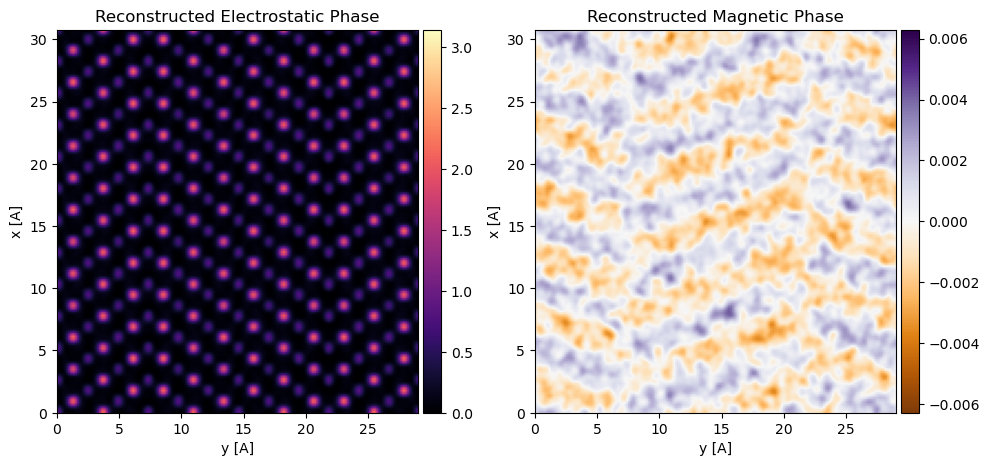

In [24]:
fig_joint, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

im1 = ax1.imshow(
    joint_electrostatic_phase.T,
    cmap='magma',
    origin='lower',
    vmax=np.pi,
    extent=extent_xy
)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im1, cax=cax, orientation='vertical')

ax1.set_title("Reconstructed Electrostatic Phase")
ax1.set_ylabel("x [A]")
ax1.set_xlabel("y [A]")

im2=ax2.imshow(
    joint_magnetic_phase.T,
    origin='lower',
    cmap='PuOr',
    vmin=-np.pi*2e-3,
    vmax=np.pi*2e-3,
    extent=extent_xy
)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax2.set_title("Reconstructed Magnetic Phase");
ax2.set_ylabel("x [A]")
ax2.set_xlabel("y [A]")

fig_joint.tight_layout();

In [31]:
# fig_joint.savefig("NiO-mix-twin_joint-recon.png",transparent=True,bbox_inches='tight')